# Trabalho 4 - Operações Geométricas

## Scanner doméstico usando um celular.

Os filhos do professor de visão computacional são aficionados por Star Wars. O maiorzinho queria uma imagem de um storm trooper como plano de fundo para o seu tablet. Contudo, o scanner de casa está quebrado e o salário do professor está muito atrasado. O pior é que o governador Pezão nem sequer diz quando vai pagar os três salário em atraso. Como a grana está curta, o professor resolveu usar câmera do celular. No entanto, é sabido que a imagem obtida pela câmera impõe à imagem original uma geometria projetiva e esta distorção precisa ser compensada já que o garoto ficou muito triste com a qualidade do resultado obtido pela câmera. Felizmente, como o pai dos meninos é professor, ele propôs que seus alunos da Uerj resolvessem este problema como trabalho para a disciplina. Para facilitar a tarefa, o professor fotografou a imagem do storm trooper sobre uma folha de papel A4 que serve como referência. Obtenha a transformação projetiva que recupere a geometria da imagem original e reconstrua-a usando a interpolação bilinear. Veja a seguir a imagem de entrada.

Faça toda a álgebra linear manualmente, das bibliotecas usadas no curso, você só pode usar as funções  ```imread``` e ```imwrite```.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance as dist

In [2]:
C = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [0, 255, 255]])

-------

#### Definição de Funções

In [3]:
def img2binary(img, threshold = 60):
    """Binarization of image with threshold given"""
    return threshold < img

In [4]:
def roberts(img):
    """Apply Roberts filter to image"""
    k_robertsx = np.array([[1, 0], [0, -1]])
    k_robertsy = np.array([[0, 1], [-1, 0]])
    robertsx = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsx, -1)))
    robertsy = cv.convertScaleAbs(cv.filter2D(img, cv.CV_64F, cv.flip(k_robertsy, -1)))
    
    return robertsx + robertsy

In [5]:
def binary_roberts(img, threshold = 60):
    """Returns roberts image in binary scale"""
    return img2binary(roberts(img), threshold).astype(np.uint8)

In [6]:
def clockwise_sort(points):
    tl = points[np.argsort(points[:, 0]), :][0]
    points = np.delete(points, np.where(np.all(points == tl, axis = 1)), axis = 0)
    bl = points[np.argsort(points[:, 1]), :][0]
    points = np.delete(points, np.where(np.all(points == bl, axis = 1)), axis = 0)
    tr = points[np.argsort(points[:, 0]), :][0]
    br = points[(points != tr)[:, 0]][0]
    
    return np.array([tl, tr, br, bl], dtype = np.int)

In [7]:
def detect_corners(img):
    """Detect corners based on non zero pixel of image object borders"""
    b = np.where(img > 0)
    p1 = np.array([b[0][np.argmin(b[0])], b[1][np.argmin(b[0])]])
    p2 = np.array([b[0][np.argmax(b[1])], b[1][np.argmax(b[1])]])
    p3 = np.array([b[0][np.argmax(b[0])], b[1][np.argmax(b[0])]])
    p4 = np.array([b[0][np.argmin(b[1])], b[1][np.argmin(b[1])]])
    p5 = np.array([b[1].min(), b[0].min()])
    p6 = np.array([b[1].min(), b[0].max()])
    p7 = np.array([b[1].max(), b[0].max()])
    p8 = np.array([b[1].max(), b[0].min()])
    
    corners = np.array([p1, p2, p3, p4, p5, p6, p7, p8])
    
    return np.unique(corners[img[corners[:,0], corners[:,1]] == 1], axis = 0)

In [8]:
def cornerfy_from_file(filein, fileout = ''):
    imgin = cv.imread(filein, 0)
    roberts_binary = binary_roberts(imgin)
    corners = detect_corners(roberts_binary)
#     save_image_with_corners(imgin, corners, fileout)
    return roberts_binary, clockwise_sort(corners)

In [9]:
def cornerfy_from_array(arrayin, fileout = ''):
    roberts_binary = binary_roberts(arrayin)
    corners = detect_corners(roberts_binary)
#     save_image_with_corners(arrayin, corners, fileout)
    return roberts_binary, clockwise_sort(corners)

In [10]:
def true_corners(img, corners):
    for i in range(len(corners)):
        if img[tuple(corners[i])] == 0:
            ind = tuple(corners[i])
            idx = np.argwhere(img)
            idx = idx[~(idx == ind).all(1)]
            corners[i] = idx[((idx - ind)**2).sum(1).argmin()]
    
    return clockwise_sort(corners)

In [11]:
def assemble_matrix(in_corners, out_corners):
    A = np.zeros((len(in_corners), 8))

    for i in range(0, len(in_corners), 2):
        A[i, 0] = in_corners[i]
        A[i, 1] = in_corners[i + 1]
        A[i, 2] = 1
        A[i, 3] = A[i, 4] = A[i, 5] = 0
        A[i, 6] = - in_corners[i] * out_corners[i]
        A[i, 7] = - in_corners[i + 1] * out_corners[i + 1]
        A[i + 1, 0] = A[i + 1, 1] = A[i + 1, 2] = 0
        A[i + 1, 3] = in_corners[i]
        A[i + 1, 4] = in_corners[i + 1]
        A[i + 1, 5] = 1
        A[i + 1, 6] = - in_corners[i] * out_corners[i]
        A[i + 1, 7] = - in_corners[i + 1] * out_corners[i + 1]
        
    return A

In [12]:
def strip_matrix(mat):
    if mat.shape[1] != 1:
        mat = mat.reshape(-1, 1)
    
    return mat

In [13]:
def geometric_transformation(in_corners, out_corners):
    in_corners = strip_matrix(in_corners)
    out_corners = strip_matrix(out_corners)
    
    A = assemble_matrix(in_corners, out_corners)
    X = np.linalg.inv(A.T @ A) @ A.T @ out_corners

    return np.array([[X[0,0], X[1,0], X[2,0]],
                     [X[3,0], X[4,0], X[5,0]],
                     [X[6,0], X[7,0], 1],])

-------

## Figuras/Imagens

Lê a figura do Stormtrooper

In [14]:
stormtrooper = cv.imread('../images/IMG_20170615_082455.jpg', 0)

Cria o painel do A4 em branco (sem intensidade nos pixels)

In [15]:
# A4 para 150 ppi
# A4 totalmente branco
A4 = np.zeros((1754, 1240), dtype = np.uint8)

Cria um losango

In [16]:
diamond = np.uint8([[(30 <= x + y) & (10 >= -x + y) & (-10 <= -x + y) & (50 >= x + y) for y in range(41)] for x in range(41)]) * 255

Cria um quadrado

In [17]:
square = np.uint8([[(x >= 10) & (x <= 30) & (y >= 10) & (y <= 30) for y in range(41)] for x in range(41)]) * 255

------

## Teste da Identificação dos Cantos

Usando as imagens do losango e do quadrado vamos testar o algoritmo para identificar os cantos da imagem.

In [18]:
diamond_roberts, diamond_corners = cornerfy_from_array(diamond)
diamond_corners = true_corners(diamond, diamond_corners)

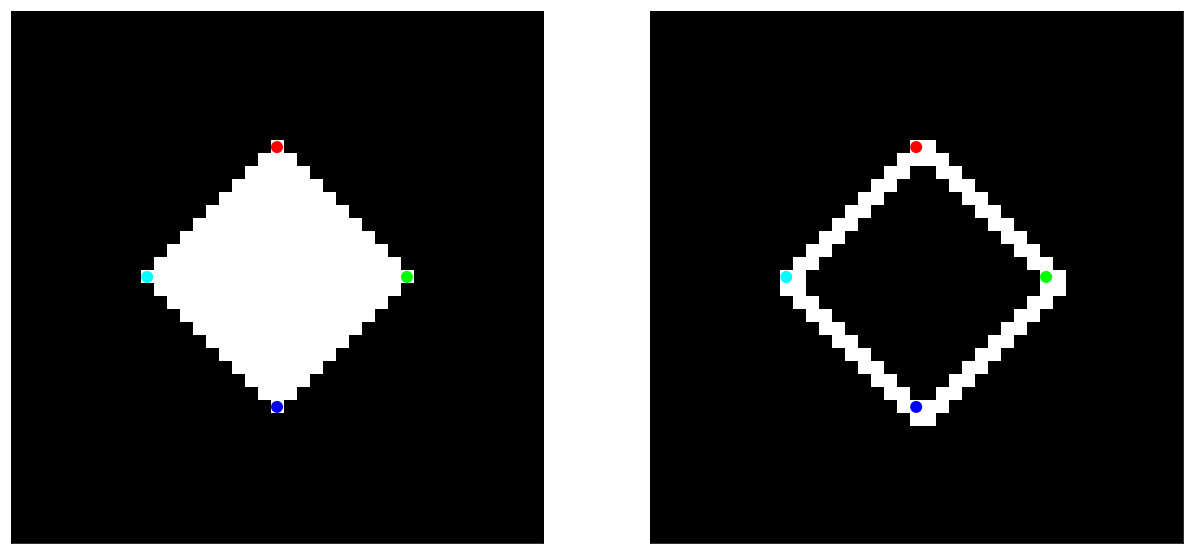

In [19]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(diamond, cmap = 'gray')
ax.scatter(diamond_corners[:,1], diamond_corners[:,0], marker = 'o', color = C/255.0, linewidths = 6)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(diamond_roberts, cmap = 'gray')
ax.scatter(diamond_corners[:,1], diamond_corners[:,0], marker = 'o', color = C/255.0, linewidths = 6)
plt.xticks([])
plt.yticks([])

plt.show()

In [20]:
square_roberts, square_corners = cornerfy_from_array(square)
square_corners = true_corners(square, square_corners)

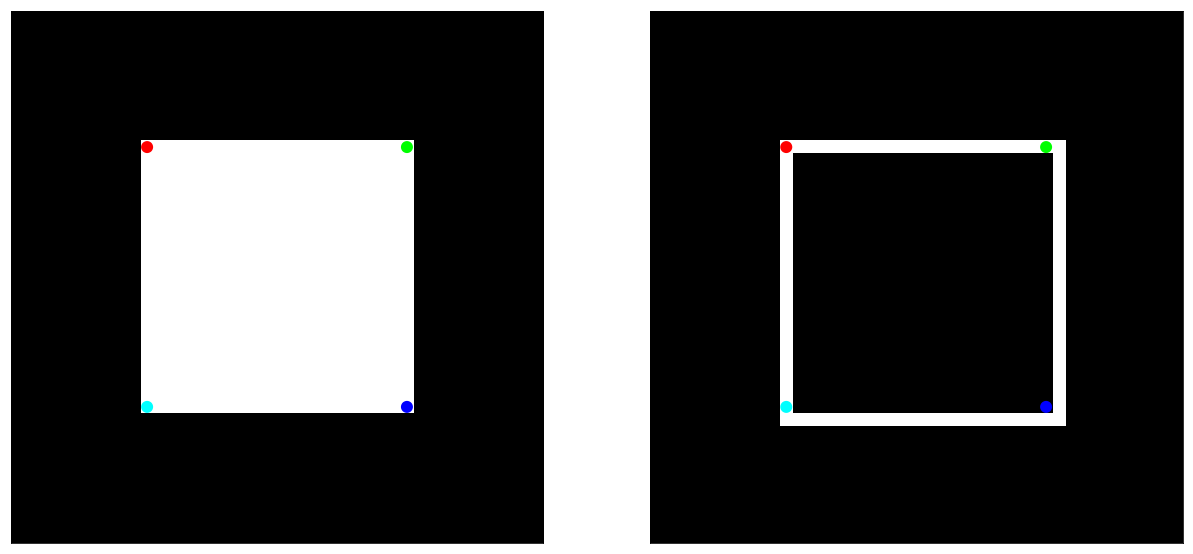

In [21]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(square, cmap = 'gray')
ax.scatter(square_corners[:,1], square_corners[:,0], marker = 'o', color = C/255.0, linewidths = 6)
plt.xticks([])
plt.yticks([])

ax = fig.add_subplot(1, 2, 2)
ax.imshow(square_roberts, cmap = 'gray')
ax.scatter(square_corners[:,1], square_corners[:,0], marker = 'o', color = C/255.0, linewidths = 6)
plt.xticks([])
plt.yticks([])
plt.show()

plt.show()

In [22]:
stormtrooper_roberts, stormtrooper_corners = cornerfy_from_array(stormtrooper)
stormtrooper_corners = true_corners(stormtrooper, stormtrooper_corners)

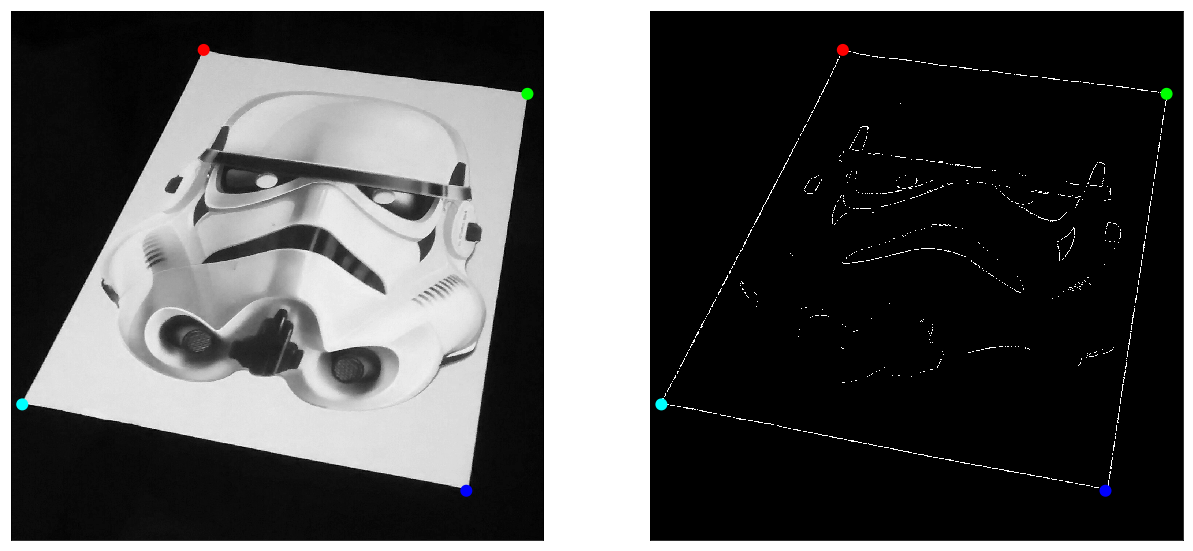

In [23]:
fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(stormtrooper, cmap = 'gray')
ax.scatter(stormtrooper_corners[:,1], stormtrooper_corners[:,0], marker = 'o', color = C/255.0, linewidths = 6)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(1, 2, 2)
ax1.imshow(stormtrooper_roberts, cmap = 'gray')
ax1.scatter(stormtrooper_corners[:,1], stormtrooper_corners[:,0], marker = 'o', color = C/255.0, linewidths = 6)
plt.xticks([])
plt.yticks([])

plt.show()

In [24]:
A4_corners = np.array([[0,0], [0, 1240], [1754, 0], [1754, 1240]])
A4_corners = clockwise_sort(A4_corners)

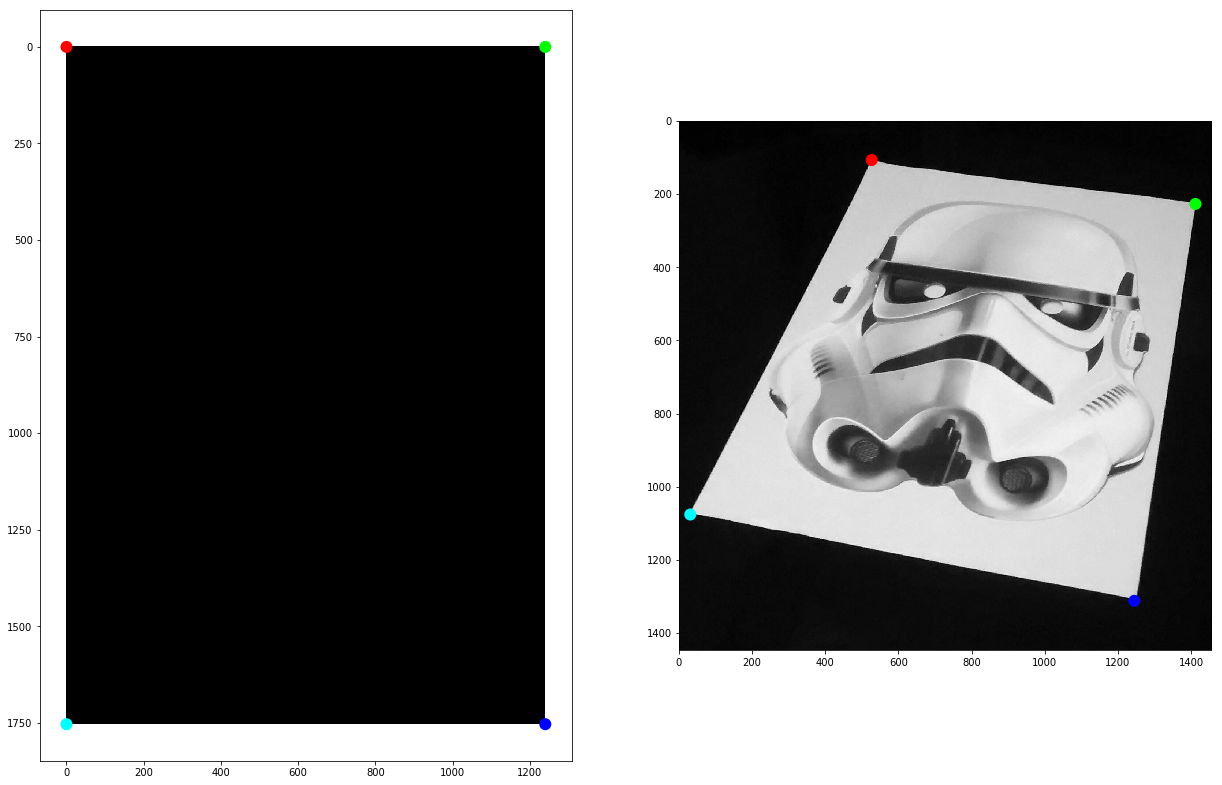

In [25]:
point = 2

fig = plt.figure(figsize = (21,15))

ax = fig.add_subplot(1, 2, 1)
ax.imshow(A4, cmap = 'gray')
ax.scatter(A4_corners[:,1], A4_corners[:,0], marker = 'o', color = C/255.0, linewidths = 6)

ax = fig.add_subplot(1, 2, 2)
ax.imshow(stormtrooper, cmap = 'gray')
ax.scatter(stormtrooper_corners[:,1], stormtrooper_corners[:,0], marker = 'o', color = C/255.0, linewidths = 6)

plt.show()

In [26]:
print(stormtrooper_corners)
print(A4_corners)

[[ 107  527]
 [ 227 1412]
 [1312 1245]
 [1076   31]]
[[   0    0]
 [   0 1240]
 [1754 1240]
 [1754    0]]


In [27]:
1240 * 1245

1543800

In [28]:
geo_mat = geometric_transformation(stormtrooper_corners, A4_corners)

In [29]:
geo_mat

array([[ 3.54357039e+01,  2.34385989e+01, -5.20572968e+04],
       [-1.04625902e+00,  2.59794778e-01, -1.13314219e+02],
       [-5.09210000e-04,  2.07798568e-04,  1.00000000e+00]])

In [30]:
np.linalg.inv(geo_mat)

array([[ 7.02263958e-03, -8.49038766e-01,  2.69371469e+02],
       [ 2.73617407e-02,  2.21271554e-01,  1.44945147e+03],
       [-2.10973225e-06, -4.78318942e-04,  8.35972705e-01]])

In [31]:
T = np.array([[3.92, 2.84, 2], [0.69, 7.07, 1], [-.15, 0.61, 1]])

In [32]:
T

array([[ 3.92,  2.84,  2.  ],
       [ 0.69,  7.07,  1.  ],
       [-0.15,  0.61,  1.  ]])

In [33]:
a = T @ np.array([0, 1, 1])

In [34]:
np.round(a / a[2])

array([3., 5., 1.])

In [35]:
b = geo_mat @ np.array([107, 527, 1])

In [36]:
np.round(b/b[2])

array([-3.404e+04, -8.400e+01,  1.000e+00])

In [37]:
b

array([-3.59135349e+04, -8.83520859e+01,  1.05502438e+00])

In [38]:
geo_mat

array([[ 3.54357039e+01,  2.34385989e+01, -5.20572968e+04],
       [-1.04625902e+00,  2.59794778e-01, -1.13314219e+02],
       [-5.09210000e-04,  2.07798568e-04,  1.00000000e+00]])

In [45]:
in_corners = strip_matrix(A4_corners)
out_corners = strip_matrix(stormtrooper_corners)
    
A = assemble_matrix(in_corners, out_corners)
X = np.linalg.inv(A.T @ A) @ A.T @ out_corners

In [46]:
X

array([[ 4.16404617e+01],
       [ 6.47286457e+01],
       [-1.11825957e+05],
       [-2.38078402e+00],
       [ 1.27714942e+01],
       [ 4.59311004e+02],
       [ 1.35391658e-03],
       [ 4.41215814e-03]])

In [47]:
A

array([[ 0.000000e+00,  0.000000e+00,  1.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  1.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  1.240000e+03,  1.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00, -1.750880e+06],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         1.240000e+03,  1.000000e+00,  0.000000e+00, -1.750880e+06],
       [ 1.754000e+03,  1.240000e+03,  1.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00, -2.301248e+06, -1.543800e+06],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.754000e+03,
         1.240000e+03,  1.000000e+00, -2.301248e+06, -1.543800e+06],
       [ 1.754000e+03,  0.000000e+00,  1.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00, -1.887304e+06,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.

In [48]:
in_corners

array([[   0],
       [   0],
       [   0],
       [1240],
       [1754],
       [1240],
       [1754],
       [   0]])

In [43]:
out_corners

array([[   0],
       [   0],
       [   0],
       [1240],
       [1754],
       [1240],
       [1754],
       [   0]])

In [44]:
np.linalg.inv(A.T @ A) @ A.T @ out_corners

array([[ 3.54357039e+01],
       [ 2.34385989e+01],
       [-5.20572968e+04],
       [-1.04625902e+00],
       [ 2.59794778e-01],
       [-1.13314219e+02],
       [-5.09210000e-04],
       [ 2.07798568e-04]])